In [1]:
#| default_exp components

%load_ext autoreload
%autoreload 2


# Transformers components to be assembled in a model

Work in progress

In [2]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device('mps')
torch.backends.mps.is_available()
g = torch.Generator().manual_seed(42)

## Embeddings

- Token embeddings, using torch embedding lookup
- Positional embedding, which can be fixed or learned.

In [3]:
#| export
class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
        
    def forward(self, x):
        return self.embedding(x)

In [4]:
vocab_size = 6
embedding_dim = 50
emb = TokenEmbeddings(vocab_size, embedding_dim=embedding_dim)
emb.to(device)
x = torch.tensor([0,1,2,1], dtype=torch.long, device=device)
emb_x = emb(x)
assert emb_x.shape==(x.shape[0],embedding_dim)
assert torch.equal(emb_x[1],emb_x[3])

### Positional Encoding

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.
So we give the model some sense of position of the token in the sequence. 

Either we give the position as an input to the model or the model learns it.

#### Non learned positional embeddings

##### Potential solutions:

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training.

Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

##### Proposed solutions:

The initial solution that was proposed isn’t a single number. Instead, it’s a d-dimensional vector that contains information about a specific position in a sentence. This vector, if not learned, is not integrated in the model.

$\begin{align}
  \vec{p_t}^{(i)} = f(t)^{(i)} & := 
  \begin{cases}
      \sin({\omega_k} . t),  & \text{if}\  i = 2k \\
      \cos({\omega_k} . t),  & \text{if}\  i = 2k + 1
  \end{cases}
\end{align} $

where $\omega_k = \frac{1}{n^{2k / d}}$

where : 
- L: sequence length
- t: position of token in input sequence
- d: dimension of positon embedding (same as token embedding)
- P(t,j): position function to map a position t in sequence to index (t,i) in positional matrix
- n: user defined scalar (ex: 10'000)
- i: index on the position embedding
- k: floor division (partie entière) of i by 2, so i = 2k (i is even - pair) or i=2k+1 (i is odd - impair), because we add a sin/cos pair on every two embedding slot

The frequency of sinusoidal is decreasing with the vector dimension (as i grows)

So we got a vector with pairs of sin/cosines for each frequency.

$\vec{p_t} = \begin{bmatrix} 
\sin({\omega_1}.t)\\ 
\cos({\omega_1}.t)\\ 
\\
\sin({\omega_2}.t)\\ 
\cos({\omega_2}.t)\\ 
\\
\vdots\\ 
\\
\sin({\omega_{d/2}}.t)\\ 
\cos({\omega_{d/2}}.t) 
\end{bmatrix}_{d \times 1}$

It's like the encoding of numbers in binary format: 

$
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}$

where last bit is alternating on every number and previous on every 2 numbers, and so on. So instead of using bits (which would be a waste of space), we use continuous float variant with sinuosidal functions..

## References

- https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://kikaben.com/transformers-positional-encoding/
- http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding
- https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3



In [5]:
#| export

class PositionalEncoder(nn.Module):
    ''' Module to encode position in a transformer like model. 
    

    Args:
        max_seq_len (int): max length of sequence, aka L
        embedding_dim (int): dimension of embeddings in model, aka d
        dropout (float):  dropout rate. 0. for no dropout. 
        is_learned (bool): true if the position is learned through gradient descent or given (non differentiable) as defined in original paper Attention is all you need, https://arxiv.org/abs/1706.03762        
        n (int): user defined scalar set by default to 10000 as in paper        
    '''    
        
    def positional_encoding(self):
        pos = torch.arange(0,self.max_seq_len).repeat(self.embedding_dim, 1)
        i = torch.arange(0,self.embedding_dim)
        k = i // 2        
        wt = pos.T/(self.n**(2*k/self.embedding_dim))
        sin = torch.sin(wt)
        cos = torch.cos(wt)
        pe = torch.zeros((self.max_seq_len,self.embedding_dim))
        pe[:,0::2]= sin[:,0::2]
        pe[:,1::2]=cos[:,1::2]
        return pe

    def __init__(self, max_seq_len: int, embedding_dim: int, dropout: float = 0.,is_learned: bool = True, n:int=10000) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.is_learned = is_learned
        self.n = n
        self.dropout = nn.Dropout(p=dropout)
        if self.is_learned:            
            pos = torch.arange(0, self.max_seq_len, dtype=torch.long).unsqueeze(0) # shape (1, max_seq_len)
            self.register_buffer('pos', pos)
            self.pos_embedding = nn.Embedding(max_seq_len, embedding_dim)
        else:
            pos_encodings = self.positional_encoding().unsqueeze(0)
            pos_encodings.requires_grad_(False)
            # a buffer is a state in module which is not a parameter (learned)
            self.register_buffer('pos_encodings',pos_encodings)

            
    def forward(self, x):
        if self.is_learned:            
            x = x + self.pos_embedding(self.pos)
        else:
            x= x + self.pos_encodings
        return self.dropout(x)            
                        
 

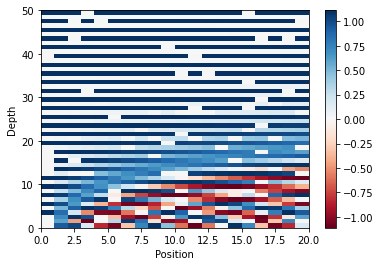

In [6]:

seq_len = 20
embedding_dim = 50
pos_enc = PositionalEncoder(max_seq_len=seq_len, embedding_dim=embedding_dim, dropout=0.1, is_learned=False) 
pos_enc.to(device)
pos_enc.positional_encoding()       
x = torch.zeros(1, seq_len, embedding_dim, device=device)
pe = pos_enc.forward(x)
np_pe = pe.cpu().detach().numpy()
plt.pcolormesh(np_pe[0].T, cmap='RdBu')
plt.xlabel('Position')
plt.ylabel('Depth')
plt.colorbar()
plt.show()

## Attention mechanisms

### attention function

In [7]:
#| export
def unidirectional_mask(seq_len:int):
    inverse_mask = torch.triu(torch.ones((1, seq_len,seq_len)), diagonal=1).type(torch.uint8)
    mask = (inverse_mask==0)
    return mask


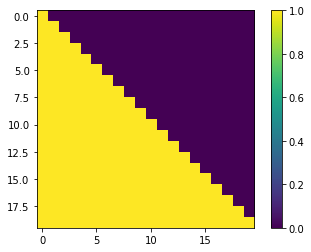

In [13]:
mask = unidirectional_mask(20)
plt.imshow(mask[0])
plt.colorbar()
plt.show()   


In [9]:
#| export
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None, dropout: torch.nn.Module=None):
    d_k = query.size(-1)    
    scores = (query @ key.transpose(-2,-1)) /(torch.sqrt(torch.tensor(d_k, requires_grad=False)))
    if mask is not None:
        # mask scores with -inf. If we masked_fill(mask, -inf), it would mask when mask ==1 (is true). We want to mask when it's 0.
        scores = scores.masked_fill(mask==0, float('-inf'))     
    soft = F.softmax(scores, dim=-1)
    if dropout is not None:        
        soft = dropout(soft)        
    atn = soft @ value
    assert atn.shape == query.shape, "atn shape should be the same as input tensors key, query, value"
    return atn


20 50


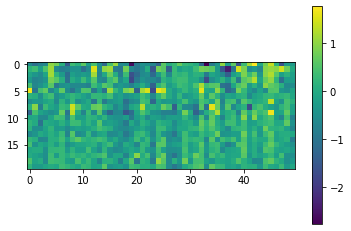

In [10]:

Q = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
K = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
V = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
print(seq_len, embedding_dim)
mask = unidirectional_mask(seq_len).to(device)
atn = attention(Q,K,V, mask=mask, dropout=torch.nn.Dropout(0.1))
plt.imshow(atn[0].cpu().numpy())
plt.colorbar()
plt.show()   


In [11]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & unidirectional_mask(tgt.size(-1)).type_as(tgt_mask.data)
        
        return tgt_mask

def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)
        

for b in data_gen(V=5, batch_size=3, nbatches=2):
    print(b.src)
    print(b.tgt)
    print(b.tgt_mask.shape)

tensor([[1, 4, 4, 4, 1, 3, 4, 3, 1, 3],
        [1, 3, 4, 4, 4, 2, 3, 3, 4, 1],
        [1, 4, 4, 3, 2, 4, 4, 4, 3, 4]])
tensor([[1, 4, 4, 4, 1, 3, 4, 3, 1],
        [1, 3, 4, 4, 4, 2, 3, 3, 4],
        [1, 4, 4, 3, 2, 4, 4, 4, 3]])
torch.Size([3, 9, 9])
tensor([[1, 4, 1, 3, 2, 3, 3, 2, 3, 2],
        [1, 4, 4, 2, 3, 1, 3, 3, 1, 4],
        [1, 2, 3, 4, 2, 1, 2, 1, 3, 3]])
tensor([[1, 4, 1, 3, 2, 3, 3, 2, 3],
        [1, 4, 4, 2, 3, 1, 3, 3, 1],
        [1, 2, 3, 4, 2, 1, 2, 1, 3]])
torch.Size([3, 9, 9])


In [12]:
src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
src_mask = torch.ones(1, 1, 10)
src, src_mask

(tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]),
 tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]))

## Attention mechanism
Based on formal algorithm for transformers (https://arxiv.org/abs/2207.09238) where it can be used for different attention architectures like 
- encoder-decoder/seq-to-seq (very first transformer), 
- encoder-only (bert), 
- decoder-only (gpt-*, gopher). 

### Encoder-decoder architecture use 2 sequences as input
- context sequence of tokens (z), which is used to encode context as a vector per token with bidirectional attention
- primary sequence of tokens (x), which is used to decode both the encoded context and a masked primary sequence (tokens in primary sequence that precedes current). This is used to train a translator from FR to EN for instance. FR tokens are the context sequence and EN tokens are the primary sequence (target)
 
### Encoder only architecture use 1 primary sequence as input
Given a primary input sequence (x) with some tokens masked out, the goal is to recover the masked tokens. the goal is to learn a generally usefull representation of text. Uses a bidirectional attention

### Decoder only architecture use 1 primary sequence as input
Autoregressive language modelling where the goal is to predict the next token of a primary token sequence (x). Uses a unidirectional attention. 

In [14]:
#| export


class MultiHeadAttention(nn.Module):
    ''' Multihead attention module as defined in Formal algorithm for transformers (https://arxiv.org/abs/2207.09238)
    It can be used for different attention architectures like encoder-decoder/seq-to-seq (very first transformer), 
    encoder-only (bert), decoder-only (gpt-*, gopher). 
    '''
    
    def __init__(self, d:int, h: int, dropout: float=0., bias:bool=True):
        super().__init__()
        g = torch.Generator().manual_seed(42)        
        self.d = d
        self.h = h
        #self.w_weights = torch.randn((d, d_in), generator=g)
        #self.k_weights = torch.randn((d, d_in), generator=g)
        #self.v_weights = torch.randn((d, d_in), generator=g)
        

    def forward(self, x: torch.Tensor, z: torch.Tensor=None, mask: torch.Tensor=None):
        '''_summary_
        
        

        Args:
            x (torch.Tensor): primary sequence 
            z (torch.Tensor): context sequence, only for encoder-decoder architecture. 
            mask (torch.Tensor, optional): _description_. Defaults to None.
        '''
        ...


e = torch.rand((1,seq_len, embedding_dim))
attn = MultiHeadAttention(d=embedding_dim, h=2)
attn(e)

TypeError: forward() missing 1 required positional argument: 'z'

In [ ]:
# test with multihead_attn = nn.MultiheadAttention(embed_dim, num_heads) so that result is the same. 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export("./components.ipynb")